## RNN with PyTorch

Phai Phongthiengtham

In this notebook, I will demonstrate how to do text classification using character-level RNN.

This notebook was adapted from PyTorch tutorial:
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

Full dataset can be downloaded from:
- https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import collections

import torch
import torch.nn as nn
from torch import optim

### Problem statement and scope

Given the name, I would like to classifiy whether the name is English or Russian. Note: the full dataset contains 18 languages. However, it is highly unbalanced, with the majority of names are English and Russian. I did the following cleaning process:

1. Replaced non-ascii to ascii characters e.g., 'Ślusàrski' => 'Slusarski'
2. Kept names with 7 characters or less

The cleaned dataset was saved to 'name_classification.csv'.

In [2]:
# read csv file and split to train and test datasets
df = pd.read_csv('./data/name_classification.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

print(df['language'].value_counts())
df.sample(5, random_state=1)

Russian    3748
English    2871
Name: language, dtype: int64


,language,name,length,label
6311,Russian,Vylkov,6,1
4469,Russian,Jagalin,7,1
311,English,Burnett,7,0
2990,Russian,Agapov,6,1
116,English,Ashe,4,0


- The label is alphabetical (0 = English, 1 = Russia).
- Next, I get a set of all characters in the dataset.

In [3]:
def get_all_character(list_names):
    c = collections.Counter()
    for name in list_names:
        c.update(name.lower())

    return c
    
c = get_all_character(df['name'].tolist())

all_characters = sorted(list(c.keys()))
print('All characters: ', ''.join(all_characters))

n_characters = len(all_characters)
n_language = len(df['language'].unique())
max_name_length = df['length'].max()

print('Total number of characters =', n_characters)
print('Total number of languages =', n_language)
print('Mamimum name length =', max_name_length)

All characters:   ',abcdefghijklmnopqrstuvwxyz
Total number of characters = 29
Total number of languages = 2
Mamimum name length = 7


- The set of all characters include " " (whitespace), "'" (apostrophe), "," (comma) and a-z. As such, we have 29 in total.
- Note that I convert all character to lowercase.

Next, I create a function that convert name into one-hot encoding tensor. 

In [4]:
def name2tensor(name: str):
    # convert name into one-hot encoding tensor 
    np_array = np.zeros((max_name_length, 1, n_characters))
    for li, letter in enumerate(name.lower()):
        np_array[li][0][all_characters.index(letter)] = 1
    return torch.from_numpy(np_array).float()

name_tensor = name2tensor('Ann')
print(name_tensor.size())
print(name_tensor)

torch.Size([7, 1, 29])
tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


This tensor has dimension of 7 x 1 x 29.
- 7 refers to maximum number of characters in a given name.
- 1 refers to one name.
- 29 refers to one-hot encoding. There 29 characters - all 0 excepts the character position.

Next, I set up the model.

### Define neural network layers, loss and optimizer

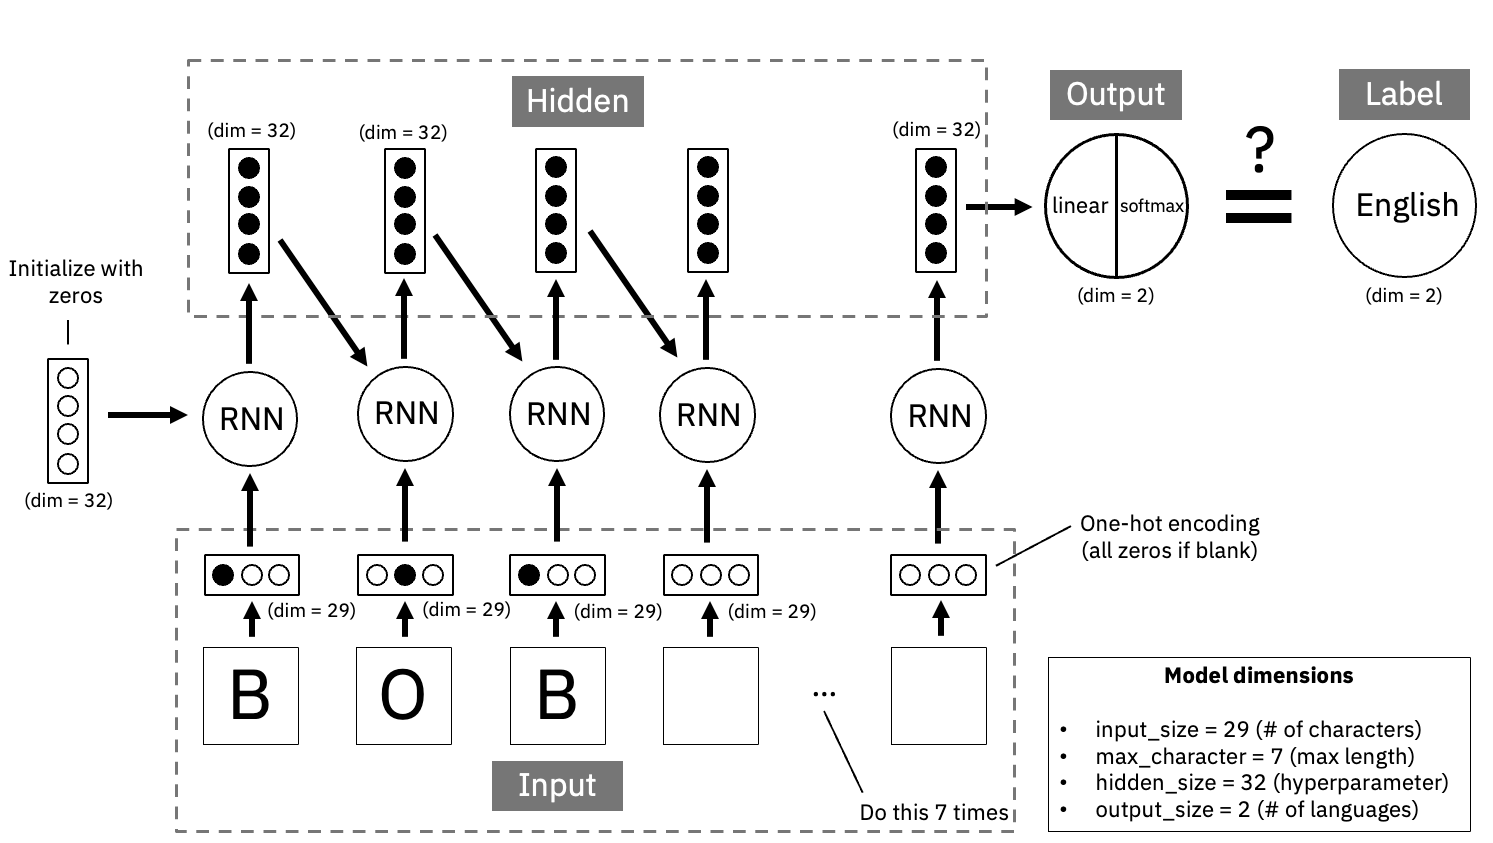

In [5]:
from IPython.display import Image
Image(filename='./figure/RNN_name_prediction.png')

With that, I need three neural network modules:
1. RNN: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
2. Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear
3. LogSoftmax: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=logsoftmax#torch.nn.LogSoftmax

LogSoftmax is the log version of softmax (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax). It is faster and has better numerical properties. 

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, bias=False)
        self.linear = nn.Linear(hidden_size, output_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        _, hn1 = self.rnn(input, hidden) #hn1 is the final hidden state of RNN
        hn2 = torch.squeeze(self.linear(hn1), 0)
        pred = self.logsoftmax(hn2)
        return pred

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, dtype=torch.float32)

hidden_size = 32
input_size = n_characters
output_size = n_language
learning_rate = 0.002

# initialize the model
model = Model(input_size, hidden_size, output_size)

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define loss function (negative log likelihood loss)
criterion = nn.NLLLoss()

### Train the model

- For eacg epoch, I pass each observation in the training data to the model one by one.
- In practice, pytorch can be trained in batches (a subset of training data). 

In [7]:
n_epochs = 5 # number of epochs

for epoch in range(n_epochs):
    for row_i, row in df_train.iterrows(): # loop by observations in the training dataset
        hidden = model.initHidden() # initialize hidden state (zero tensor)
        name_tensor = name2tensor(row['name']) # get tensor for name (X)
        target_tensor = torch.tensor([row['label']], dtype=torch.long) # get tensor for target (y)

        # model training and parameters updating
        pred = model(name_tensor, hidden) # forward propagation
        loss = criterion(pred, target = target_tensor) # compute loss
        loss.backward() # backward propagation
        optimizer.step() # update weights
        optimizer.zero_grad() # clear gradient vectors

### Make predictions and evaluate the model

Training is done! Now I use test dataset to evaluate. 

In [8]:
def make_prediction(name: str):
    # make prediction given name
    pred_numpy = model(name2tensor(name), hidden).detach().numpy()
    predicted_label = np.argmax(pred_numpy)
    return predicted_label  

print(make_prediction('Dimitri'))

1


In [9]:
# make predictions to the whole test dataset
df_test['predict'] = df_test['name'].apply(lambda x: make_prediction(x))
df_test.sample(10, random_state=11)

,language,name,length,label,predict
4987,Russian,Lozovoy,7,1,1
1287,English,Jacob,5,0,0
1205,English,Hook,4,0,1
5312,Russian,Nuikin,6,1,1
5175,Russian,Mischuk,7,1,1
390,English,Coleman,7,0,0
6423,Russian,Yuhnev,6,1,1
2596,English,Treble,6,0,0
5772,Russian,Shirdov,7,1,1
4668,Russian,Jivago,6,1,1


In [10]:
# get accuracy and confusion matrix
print('Accuracy =', accuracy_score(df_test['label'], df_test['predict']), '\n')
print('Confusion matrix:\n')
print(confusion_matrix(df_test['label'], df_test['predict']))

Accuracy = 0.8602719033232629 

Confusion matrix:

[[436 106]
 [ 79 703]]
